# Modelling of Covid-19 evolution
    Emilio Fernandez Lavado

In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import networkx as nx 
import tqdm


## 1. Importance of R0 for flattening the curve

The function get_trajectory computes the evolution of the infected cases for different SIR model parameters such as gamma or initial infected cases.

In [2]:
def get_trajectory(gamma, R0, I0, N, tend=300):
    N = int(N)
    record = {}
    record['t'] = []
    record['I'] = []
    record['S'] = []
    beta = R0*gamma
    dt = 0.1 
    S = N-I0
    I = I0
    for i in range(0,tend):
        for step in range(0,int(1/dt)):   

            record['t'] += [i+dt*step]
            record['I'] += [I]
            record['S'] += [S]
            dIdt = dt*((beta/N) * S * I - gamma*I)
            dSdt = -dt*((beta/N) * S * I)
            new_S = S + dSdt
            new_I = I + dIdt
            S = new_S
            I = new_I
               
    return np.array([np.array(record['t']),np.array(record['S']),np.array(record['I'])])


The evolution of infected cases is shown for different values of the reproductive number

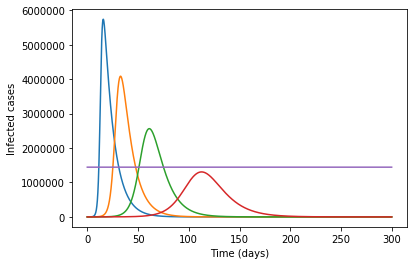

In [3]:
N = 8500000             # Switzerland population approx.
I0 = 100                # inital infected cases
R0s = [10,5,3,2]        # different RO values to check influence on max infected peak
gamma = 1/10

# compute maximal infected peak
trajectory1 = get_trajectory(gamma,R0s[0],I0,N, tend=300)
trajectory2 = get_trajectory(gamma,R0s[1],I0,N, tend=300)
trajectory3 = get_trajectory(gamma,R0s[2],I0,N, tend=300)
trajectory4 = get_trajectory(gamma,R0s[3],I0,N, tend=300)
y = np.full_like(trajectory1[0], N*0.17 , dtype = int)

# `plot maximal infected peak
plt.figure()
plt.plot(trajectory1[0],trajectory1[2])
plt.plot(trajectory2[0],trajectory2[2])
plt.plot(trajectory3[0],trajectory3[2])
plt.plot(trajectory4[0],trajectory4[2])
plt.plot(trajectory1[0],y)
plt.xlabel("Time (days)" )
plt.ylabel("Infected cases")
plt.show()



## 2. Influence of policies on pandemic control
Now get_trajectory directly returns the maximal peak of infected cases over the whole duration of the pandemic for simplification purposes

In [6]:
def get_trajectory(gamma, I0, N, tend=1000, modulation = False): 
    record = {}
    record['t'] = []
    record['I'] = []
    record['S'] = []
    dt = 0.1 
    S = N-I0
    I = I0
    for i in range(0,tend):
        if modulation:
            # no careful days post quarantine
            if len(modulation['days']) == 3:
                if i <= modulation['days'][0]:
                    R0 = modulation['R0'][0]
                elif i > modulation['days'][0] and i <= (modulation['days'][0]+modulation['days'][1]):
                    R0 = modulation['R0'][1]
                elif i > (modulation['days'][0]+modulation['days'][1]):
                    R0 = modulation['R0'][2]
            
            # careful days post quarantine
            elif len(modulation['days']) == 4:
                if i <= modulation['days'][0]:
                    R0 = modulation['R0'][0]
                elif i > modulation['days'][0] and i <= (modulation['days'][0]+modulation['days'][1]):
                    R0 = modulation['R0'][1]
                elif i > (modulation['days'][0]+modulation['days'][1]) and i <= (modulation['days'][0]+modulation['days'][1]+modulation['days'][2]):
                    R0 = modulation['R0'][2]
                elif i > (modulation['days'][0]+modulation['days'][1]+modulation['days'][2]):
                    R0 = modulation['R0'][3]
                    
        beta = R0*gamma
        for step in range(0,int(1/dt)):   
            record['I'] += [I]
            record['S'] += [S]
            dIdt = dt*((beta/N) * S * I  - gamma*I)
            dSdt = -dt*((beta/N) * S * I)
            new_S = S + dSdt
            new_I = I + dIdt
            S = new_S
            I = new_I
             
    return np.max(np.array(record['I']))/N,np.array(record['I'])

We compute the maximal infected peak for different reproductive numbers in combination with different policy durations.

{'days': [100, 200.0, 700.0], 'R0': [2.3, 0.5, 2.3]}


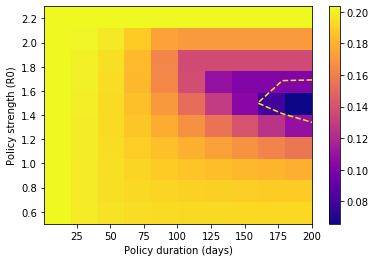

In [12]:
N =1e7
gamma = 1/20
I0 = 100
R0s = np.linspace(2.3,0.5,10)
policy_days = np.linspace(1,200,10)
modulation = {}
matrix = np.zeros((len(R0s),len(policy_days)))

for R0 in R0s:
    for days in policy_days:
        #modulation['days'] stands for the number of days with stay in a given policy
        modulation['days'] = [100,days,1000 - (days+100)]  
        #modulation['r0'] stands for the restrictive strength of a given policy
        modulation['R0'] = [2.3,R0,2.3]
        max_I,_ = get_trajectory(gamma,I0,N, tend=1000, modulation = modulation)
        matrix[np.where(R0s == R0)[0][0],np.where(policy_days == days)[0][0]] = max_I
        
print(modulation)       
plt.imshow(matrix,extent=[policy_days[0],policy_days[-1],R0s[-1],R0s[0]],aspect = 'auto',cmap ='plasma')
plt.xlabel('Policy duration (days)')
plt.ylabel('Policy strength (R0)')
plt.colorbar()
plt.contour(policy_days,R0s,matrix,[0,0.1],linestyles = 'dashed') ## shows 10% contour
plt.show()

We include 150 days of careful transitioning (R0 =1.5) from the restrictive policies to the normal situation, again for different reproductive numbers and different policy durations

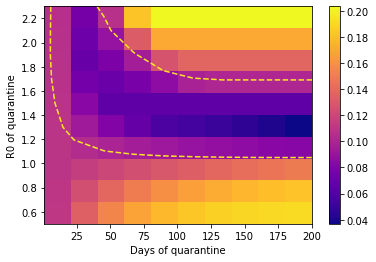

In [8]:
N =1e7
gamma = 1/20
I0 = 100
careful_days = 150
R0_careful = 1.5
R0s = np.linspace(2.3,0.5,10)
policy_days = np.linspace(1,200,10)
matrix = np.zeros((len(R0s),len(policy_days)))
modulation = {}

for R0 in R0s: 
     for days in policy_days:
        #modulation['days'] stands for the number of days with stay in a given policy
        modulation['days'] = [100,days,careful_days,1000 - (100+days+careful_days)]  
        #modulation['r0'] stands for the strength of a given polic
        modulation['R0'] = [2.3,R0,R0_careful,2.3]
        max_I,_ = get_trajectory(gamma,I0,N, tend=1000, modulation = modulation)
        matrix[np.where(R0s == R0)[0][0],np.where(policy_days == days)[0][0]] = max_I
        
plt.imshow(matrix,extent=[policy_days[0],policy_days[-1],R0s[-1],R0s[0]],aspect = 'auto',cmap ='plasma')
plt.xlabel('Days of quarantine')
plt.ylabel('R0 of quarantine')
plt.colorbar()
plt.contour(policy_days,R0s,matrix,[0,0.1],linestyles = 'dashed') ## shows 10% contour
plt.show()

We check the influence of the timing of restriction adoption for a fixed duration (50 days) for careful population and non-careful population

WARNING    <ipython-input-10-3cc8750bc612>:30: UserWarning: No contour levels were found within the data range.
  plt.contour(before_days,R0s,matrix,[0,0.1],linestyles = 'dashed') ## shows 10% contour
 [py.warnings]


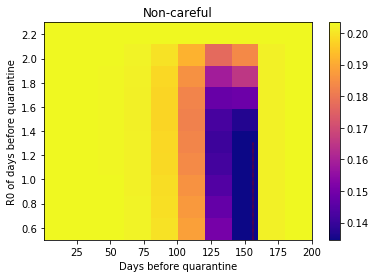

{'days': [200.0, 50, 150, 600.0], 'R0': [2.3, 0.5, 1.5, 2.3]}


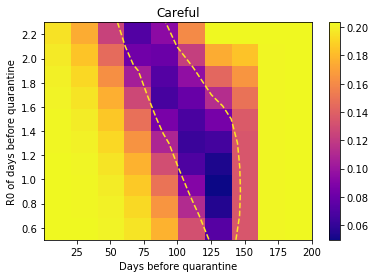

In [10]:
N =1e7
gamma = 1/20
I0 = 100
R0s = np.linspace(2.3,0.5,10)
before_days = np.linspace(1,200,10)
policy_days = 50
matrix = np.zeros((len(R0s),len(before_days)))

# non-careful
modulation = {}

for R0 in R0s:
    for days in before_days:
        #modulation['days'] stands for the number of days with stay in a given policy
        modulation['days'] = [days,policy_days,1000 - (days+policy_days)] 
        #modulation['r0'] stands for the strength of a given policy
        modulation['R0'] = [2.3,R0,2.3]
        max_I,_ = get_trajectory(gamma,I0,N, tend=1000, modulation = modulation)
        matrix[np.where(R0s == R0)[0][0],np.where(before_days == days)[0][0]] = max_I
        
        
plt.figure()
plt.imshow(matrix,extent=[before_days[0],before_days[-1],R0s[-1],R0s[0]],aspect = 'auto',cmap ='plasma')
plt.xlabel('Days before quarantine')
plt.ylabel('R0 of days before quarantine')
plt.title('Non-careful')
plt.colorbar()
plt.contour(before_days,R0s,matrix,[0,0.1],linestyles = 'dashed') ## shows 10% contour
plt.show()

# careful
careful_days = 150
R0_careful = 1.5
modulation = {}

for R0 in R0s: 
     for days in before_days:
        #modulation['days'] stands for the number of days with stay in a given policy
        modulation['days'] = [days,policy_days,careful_days,1000 - (days+policy_days+careful_days)]  
        #modulation['r0'] stands for the strength of a given polic
        modulation['R0'] = [2.3,R0,R0_careful,2.3]
        max_I,_ = get_trajectory(gamma,I0,N, tend=1000, modulation = modulation)
        matrix[np.where(R0s == R0)[0][0],np.where(before_days == days)[0][0]] = max_I

print(modulation)       
plt.figure()
plt.imshow(matrix,extent=[before_days[0],before_days[-1],R0s[-1],R0s[0]],aspect = 'auto',cmap = 'plasma')
plt.xlabel('Days before quarantine')
plt.ylabel('R0 of days before quarantine')
plt.title('Careful')
plt.colorbar()
plt.contour(before_days,R0s,matrix,[0,0.1],linestyles = 'dashed') ## shows 10% contour
plt.show()


## 3. Network-based models for epidemic analysis

In [ ]:
class cluster_Graph:
    def __init__(self,N, clusters = 0, P_intra = 1, P_extra = 1):
        self.N = N
        self.nodes = np.arange(N)
        self.clusters = clusters
        self.P_intra = P_intra
        self.P_extra = P_extra
        if self.clusters > 0:
                self.c_nodes = self.nodes.copy()
                self.c_nodes = self.c_nodes.reshape(self.clusters,-1)
        else:
            print("Network with 0 clusters")
        self.create_graph()
    def create_graph(self):
        self.Matrix = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(0,self.N):
                if  j != i:
                    if (np.where(self.c_nodes==j)[0][0]==np.where(self.c_nodes==i)[0][0]) and (np.random.rand() < self.P_intra): 
                        self.Matrix[i,j] = self.Matrix[j,i] = 1
                    elif np.random.rand() < self.P_extra:# test if i and j are in different clusters and test probability to create a link
                        self.Matrix[i,j] = self.Matrix[j,i] = 1


Random regular graph with 50 nodes

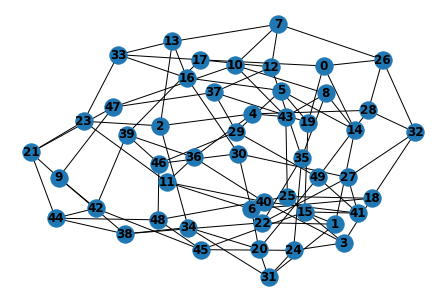

In [16]:
N = 50                     #number of nodes
s = 0.1                    #sparsity -> probability of connection been made
d = int ((N-1)*s)          #degree of each node
G1 = nx.random_regular_graph(d, N,0) 
nx.draw(G1, with_labels=True, font_weight='bold')

Cluster graph with 50 nodes

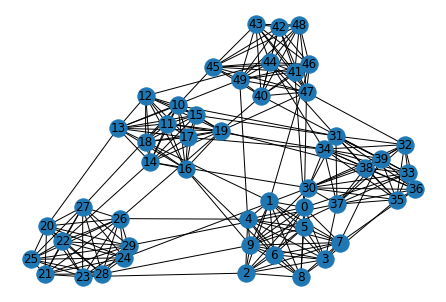

In [19]:
N = 50 #total nodes
C = 5 #total clusters
P_in = 1
P_ex = 0.02
g = cluster_Graph (N,C,P_in,P_ex)
G=nx.from_numpy_matrix(g.Matrix) #create graph from binary matrix
nx.draw(G, with_labels=True)

The funciton below (simulation_graph) computes the number of susceptible, infected and recovered nodes at each time step using probability functions 

In [ ]:
def simulation_graph(G,I0,sparsity,tend=1000 ,modulation = False):
    dt = 0.1
    gamma = 1/20
    R0s= []
    average = 10 # number of run  for averaging
    N = len(G.adj)
    arr_I = np.zeros((average,tend)) #save all infection history over time for each trial 
    arr_S = np.zeros((average,tend)) #save all susceptible history over time for each trial 
    
    for trial in range(average):
        I_t = []
        S_t = []
        infected = sorted(np.random.choice(np.arange(N),I0))
        susceptible = np.arange(N)
        susceptible = [x for x in susceptible if x not in infected] # no infected in susceptible
        cured = []
        for i in tqdm.tqdm(range(tend)):
            if modulation:
                if i <= modulation['days'][0]:
                    R0 = modulation['R0'][0]
                elif i > modulation['days'][0] and i <= (modulation['days'][0]+modulation['days'][1]):
                    R0 = modulation['R0'][1]
                elif i > (modulation['days'][0]+modulation['days'][1]) and i <= (modulation['days'][0]+modulation['days'][1]+modulation['days'][2]):
                    R0 = modulation['R0'][2]
                elif i > (modulation['days'][0]+modulation['days'][1]+modulation['days'][2]):
                    R0 = modulation['R0'][3]        
            R0s += [R0]
            beta = R0*gamma
            for step in range(0,int(1/dt)):
                tmp_infected = np.array(infected)
                tmp_cured = np.array(cured)
                for node in G.adj: ## run over all connections of a node
                    if node in infected:
                        for S_node in G.adj[node] :
                            if (np.random.rand()< beta*dt/(N*sparsity)) and (S_node in susceptible):
                                tmp_infected = np.append(tmp_infected,S_node)
                        if np.random.rand() < gamma*dt:
                            tmp_cured = np.append(tmp_cured,node)
                infected  = [x for x in tmp_infected if x not in tmp_cured]
                susceptible = [x for x in susceptible if x not in infected]
                cured = sorted(tmp_cured)
            I_t += [len(infected)]
            S_t += [len(susceptible)]
            
        arr_I[trial,:] = np.array(I_t)
        arr_S[trial,:] = np.array(S_t)
    
    return arr_S, arr_I

In [21]:
s=0.1
N=550
C=5
P_in = 1
K=N/C
P = (s*N-P_in*K)/(N-K)

# CLUSTER GRAPH
policy = {'days':[50,100,150,200],'R0':[5,3,1,2]}
g_nonmean = cluster_Graph (N,C,P_in,P)
G_nonmean=nx.from_numpy_matrix(g_nonmean.Matrix) 
S_nonmean,I_nonmean=simulation_graph(G_nonmean,I0=10,sparsity=0.1,tend=300 ,modulation = policy)
I_average_nonmean = np.mean(I_nonmean,axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.82it/s]


In [22]:
# REGULAR SPARSE GRAPH
N=550
G_regular = nx.random_regular_graph(int (N*0.1),N,0) 
S_regular, I_regular = simulation_graph(G_regular,I0=10,sparsity=0.1,tend=300,modulation=policy)
I_average_regular = np.mean(I_regular,axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:13<00:00, 22.53it/s]


In [ ]:
# SIR MODEL
max_I,I_model = get_trajectory(gamma=1/20,I0=10,N=550, tend=300, modulation=policy)

We compute and plot the evolution of the infected cases for the case of a regular random graph, a cluster graph and a SIR model 

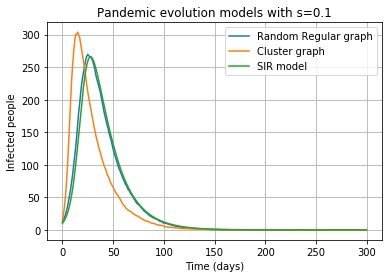

In [25]:
tend = 300
plt.plot(list(range(tend)),I_average_regular,label='Random Regular graph')
plt.plot(list(range(tend)),I_average_nonmean,label='Cluster graph')
plt.plot(list(np.arange(len(I_model))/10),I_model,label='SIR model')
plt.xlabel("Time (days)" )
plt.ylabel("Infected people")
plt.title("Pandemic evolution models with s=0.1")
plt.grid()
plt.legend()